dataset_name: co2_mlo_surface-insitu_1_ccgg_MonthlyData


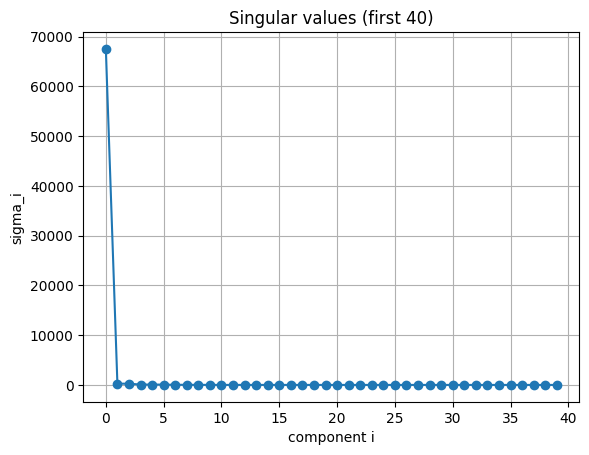

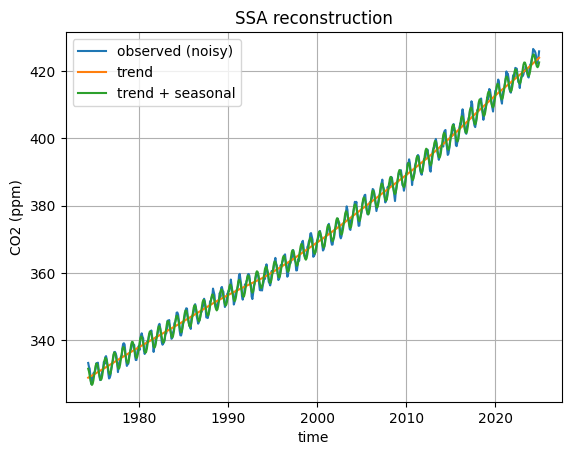

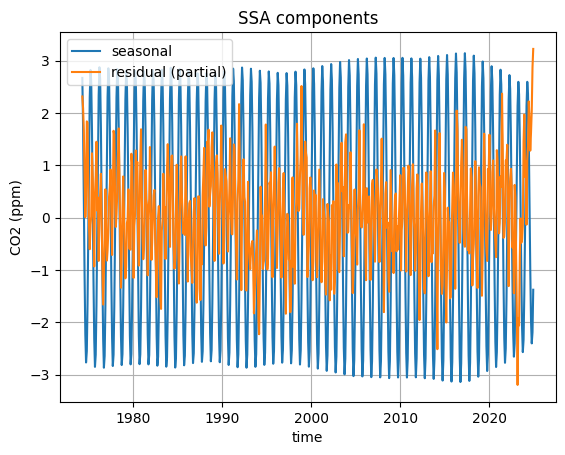

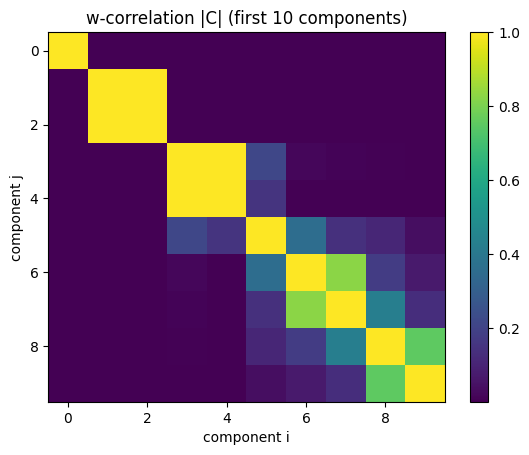

In [2]:
from __future__ import annotations

import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests


# NOAA/GML の Mauna Loa 月次 CO2（テキスト）
NOAA_CO2_MONTHLY_TXT_URL = (
    "https://gml.noaa.gov/aftp/data/trace_gases/co2/in-situ/surface/txt/"
    "co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt"
)


@dataclass
class SSAResult:
    # 窓長 L（埋め込み次元）
    L: int
    # trajectory / Hankel 行列 X（形状: L x K）
    X: np.ndarray
    # SVD: X = U diag(s) V^T（full_matrices=False なので U: L x r, V^T: r x K）
    U: np.ndarray
    s: np.ndarray
    Vt: np.ndarray


def download_file(url: str, dst: Path) -> None:
    """URLからファイルをダウンロードして保存する（既にある場合は呼ばない想定）。"""
    dst.parent.mkdir(parents=True, exist_ok=True)
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(dst, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 256):
                if chunk:
                    f.write(chunk)


def parse_header_block(path: Path, max_scan_lines: int = 10000) -> Tuple[int, List[str], Dict[str, str]]:
    """
    先頭ヘッダ領域（主に '#' で始まるメタデータ）を読み、
      - header_lines の数値
      - ヘッダ行そのもの（文字列リスト）
      - "# key: value" 形式のメタデータ辞書
    を抽出する。

    注意:
    - あなたのファイルでは "header_lines : 159" のように書かれている。
    - さらに、"VARIABLE ORDER" の「列名行」が header_lines の最終行に含まれているケースがある。
      その場合、skiprows は header_lines-1 が必要（列名行を残すため）。
    """
    header_n = None
    header_text: List[str] = []
    meta: Dict[str, str] = {}

    header_pat = re.compile(r"header_lines\s*:\s*(\d+)", re.IGNORECASE)
    kv_pat = re.compile(r"^\s*#\s*([A-Za-z0-9_]+)\s*:\s*(.*\S)\s*$")

    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for _ in range(max_scan_lines):
            line = f.readline()
            if not line:
                break

            # '#' で始まる行はヘッダ領域として保存（人間が後で確認する用途）
            if line.lstrip().startswith("#"):
                header_text.append(line.rstrip("\n"))

            m = header_pat.search(line)
            if m and header_n is None:
                header_n = int(m.group(1))

            mkv = kv_pat.match(line)
            if mkv:
                meta[mkv.group(1)] = mkv.group(2)

            # header_lines が見つかったら、本来はそこで打ち切っても良いが、
            # ヘッダ全体を保存しておくと後でデータ仕様確認に使えるため続行している。
            # （必要なら break にして高速化してOK）
            # pass

    if header_n is None:
        # header_lines が見つからないファイルにも対応するフォールバック
        header_n = 0

    return header_n, header_text, meta


def _read_table_with_skiprows(path: Path, skiprows: int) -> pd.DataFrame:
    """
    指定した skiprows で「表データ領域」を DataFrame として読む。
    このファイル形式では、表の先頭行が列名（site_code year month ...）であることを期待して header=0。
    """
    df = pd.read_csv(
        path,
        sep=r"\s+",
        skiprows=max(skiprows, 0),
        header=0,
        na_values=[-999.99, -999.990, -999.9],
        engine="python",
    )
    return df


def load_noaa_co2_monthly(path: Path) -> Tuple[pd.Series, Dict[str, str], List[str]]:
    """
    NOAAテキストから「月次の CO2 時系列（pandas.Series）」を作る。

    方針:
    - 先頭ヘッダから header_lines を読み取る
    - まず skiprows=header_lines-1 で読む（列名行が header_lines の最終行にある場合に対応）
    - もし列名が取れていなければ skiprows=header_lines で読み直す（別形式のフォールバック）
    - 以降は列名ベースで抽出するので、列位置ズレに強い
    """
    header_n, header_text, meta = parse_header_block(path)

    # あなたのケース（列名行が header_lines の最終行）では header_n-1 が正しい
    df = _read_table_with_skiprows(path, skiprows=header_n - 1)

    # 期待する列名が無い場合は 1行ズレの可能性があるのでフォールバックする
    if ("year" not in df.columns) or ("month" not in df.columns):
        df2 = _read_table_with_skiprows(path, skiprows=header_n)
        if ("year" in df2.columns) and ("month" in df2.columns):
            df = df2
        else:
            raise ValueError(
                "Failed to locate table header (columns like 'year'/'month').\n"
                f"try1 skiprows={header_n-1} columns={list(df.columns)[:20]}\n"
                f"try2 skiprows={header_n} columns={list(df2.columns)[:20]}"
            )

    # site_code があるなら MLO のみに絞る（このデータは先頭が MLO である想定）
    if "site_code" in df.columns:
        df = df[df["site_code"].astype(str).str.upper() == "MLO"].copy()

    # CO2値の列名候補（このファイルでは 'value' が入っていることが多い）
    value_col_candidates = ["value", "co2", "co2_ppm", "co2ppm", "average", "mean"]
    value_col = None
    for c in value_col_candidates:
        if c in df.columns:
            value_col = c
            break
    if value_col is None:
        # ここに入る場合は列名が想定と違うので、列名一覧を出して調整するのが安全
        raise ValueError(f"Cannot find CO2 value column. columns={list(df.columns)}")

    # year/month/value を数値化（文字列混入や空欄を検出したら落とす）
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["month"] = pd.to_numeric(df["month"], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=["year", "month", value_col]).copy()

    # to_datetime に渡すため year/month を int 化（float のままだと嫌がる環境がある）
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].astype(int)

    # 月次インデックス（各月1日）を作り、Series 化
    idx = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    s = pd.Series(df[value_col].to_numpy(dtype=float), index=idx).sort_index()

    # 月初（MS）に揃える：欠測月があれば NaN が立つので補間
    s = s.asfreq("MS")
    s = s.interpolate(limit_direction="both")

    return s, meta, header_text


def trajectory_matrix(x: np.ndarray, L: int) -> np.ndarray:
    """
    SSAステップ1（埋め込み）:
    x[0..N-1] から trajectory / Hankel 行列 X（L x K）を作る。
    数式（0-based）: X_{i,j} = x_{i+j}
    """
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if not (2 <= L <= N - 1):
        raise ValueError(f"L must satisfy 2 <= L <= N-1. Got L={L}, N={N}.")

    K = N - L + 1
    X = np.empty((L, K), dtype=float)

    # 列 j に、長さ L の部分列 x[j : j+L] をそのまま入れる（遅れベクトル）
    for j in range(K):
        X[:, j] = x[j : j + L]

    return X


def diagonal_averaging(X: np.ndarray) -> np.ndarray:
    """
    SSAステップ4（対角平均 / hankelization）:
    行列 X（L x K）から長さ N=L+K-1 の系列 y を復元する。
    数式（0-based）: y_t = (1/n_t) * sum_{i+j=t} X_{i,j}
    """
    L, K = X.shape
    N = L + K - 1

    y = np.zeros(N, dtype=float)  # 反対角線ごとの合計
    w = np.zeros(N, dtype=float)  # 反対角線ごとの要素数（= n_t）

    for i in range(L):
        for j in range(K):
            t = i + j
            y[t] += X[i, j]
            w[t] += 1.0

    return y / w


def ssa_fit(x: np.ndarray, L: int) -> SSAResult:
    """
    SSAステップ1+2:
    (1) trajectory matrix X を作る
    (2) SVD で X = U diag(s) V^T に分解する
    """
    X = trajectory_matrix(x, L)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    return SSAResult(L=L, X=X, U=U, s=s, Vt=Vt)


def reconstruct_matrix(ssa: SSAResult, indices: Sequence[int]) -> np.ndarray:
    """
    SSAステップ3（グルーピング）:
    指定成分 indices のみで X^(I) = sum_{i in I} sigma_i u_i v_i^T を作る。
    """
    idx = np.array(list(indices), dtype=int)

    U_I = ssa.U[:, idx]       # L x m
    s_I = ssa.s[idx]          # m
    Vt_I = ssa.Vt[idx, :]     # m x K

    # (U_I * s_I) は列ごとに sigma を掛けて [sigma_i u_i] を作るのと同じ
    return (U_I * s_I) @ Vt_I


def reconstruct_series(ssa: SSAResult, indices: Sequence[int]) -> np.ndarray:
    """グループ行列を作り、対角平均で系列へ戻す（SSAステップ3+4）。"""
    X_I = reconstruct_matrix(ssa, indices)
    return diagonal_averaging(X_I)


def weights_for_wcorr(L: int, K: int) -> np.ndarray:
    """
    w-correlation 用の重み w_t を作る。
    対角平均での反対角線要素数 n_t と同型の重み（端点補正）を使うのが典型。
    """
    N = L + K - 1
    w = np.zeros(N, dtype=float)

    for t in range(N):
        tt = t + 1
        w[t] = min(tt, L, K, N - tt + 1)

    return w


def wcorr_matrix(components: List[np.ndarray], L: int, K: int) -> np.ndarray:
    """
    再構成系列どうしの w-correlation 行列を作る。
    rho_w(x,y) = <x,y>_w / (||x||_w ||y||_w),  <x,y>_w = sum_t w_t x_t y_t
    """
    w = weights_for_wcorr(L, K)
    m = len(components)
    C = np.zeros((m, m), dtype=float)

    for i in range(m):
        xi = components[i]
        ni = np.sqrt(np.sum(w * xi * xi))

        for j in range(m):
            xj = components[j]
            nj = np.sqrt(np.sum(w * xj * xj))

            num = np.sum(w * xi * xj)
            C[i, j] = num / (ni * nj + 1e-15)

    return C


def main() -> None:
    # いつもの「カレント直下 ./data」に保存する（あなたの配置と一致）
    data_dir = Path("data")
    txt_path = data_dir / "co2_mlo_monthly.txt"

    # 無ければネットから取得
    if not txt_path.exists():
        print("Downloading NOAA/GML Mauna Loa monthly CO2...")
        download_file(NOAA_CO2_MONTHLY_TXT_URL, txt_path)

    # 読み込み（メタデータも保持して返す）
    s, meta, header_text = load_noaa_co2_monthly(txt_path)

    # 任意：データセット名を表示（“何のデータか分からなくなる”問題を回避）
    if "dataset_name" in meta:
        print("dataset_name:", meta["dataset_name"])

    x_clean = s.to_numpy(dtype=float)

    # SSAの挙動が見やすいように、追加でホワイトノイズを足して“ノイズ入り”にする
    rng = np.random.default_rng(0)
    noise_std = 0.6
    x = x_clean + rng.normal(0.0, noise_std, size=x_clean.shape[0])

    # 窓長 L：月次なので 12（年周期）の倍数が扱いやすいことが多い
    L = 60
    ssa = ssa_fit(x, L)

    # 特異値のスクリープロット
    plt.figure()
    plt.plot(ssa.s[:40], marker="o")
    plt.title("Singular values (first 40)")
    plt.xlabel("component i")
    plt.ylabel("sigma_i")
    plt.grid(True)

    # 手動グルーピング例（必要に応じて調整）
    trend_idx = [0]
    seasonal_idx = [1, 2]  # 正弦波が rank-2 になりやすく、ペアで出やすい経験則
    residual_idx = list(range(3, min(30, len(ssa.s))))

    x_trend = reconstruct_series(ssa, trend_idx)
    x_seasonal = reconstruct_series(ssa, seasonal_idx)
    x_residual = reconstruct_series(ssa, residual_idx)

    # 再構成の可視化
    plt.figure()
    plt.plot(s.index, x, label="observed (noisy)")
    plt.plot(s.index, x_trend, label="trend")
    plt.plot(s.index, x_trend + x_seasonal, label="trend + seasonal")
    plt.title("SSA reconstruction")
    plt.xlabel("time")
    plt.ylabel("CO2 (ppm)")
    plt.legend()
    plt.grid(True)

    plt.figure()
    plt.plot(s.index, x_seasonal, label="seasonal")
    plt.plot(s.index, x_residual, label="residual (partial)")
    plt.title("SSA components")
    plt.xlabel("time")
    plt.ylabel("CO2 (ppm)")
    plt.legend()
    plt.grid(True)

    # w-correlation（最初の m 成分）
    m = 10
    elementary_series = []
    for i in range(m):
        Xi = ssa.s[i] * np.outer(ssa.U[:, i], ssa.Vt[i, :])
        elementary_series.append(diagonal_averaging(Xi))

    L_, K_ = ssa.X.shape
    C = wcorr_matrix(elementary_series, L_, K_)

    plt.figure()
    plt.imshow(np.abs(C), aspect="auto")
    plt.title("w-correlation |C| (first 10 components)")
    plt.xlabel("component i")
    plt.ylabel("component j")
    plt.colorbar()

    plt.show()


if __name__ == "__main__":
    main()


dataset_name: co2_mlo_surface-insitu_1_ccgg_MonthlyData


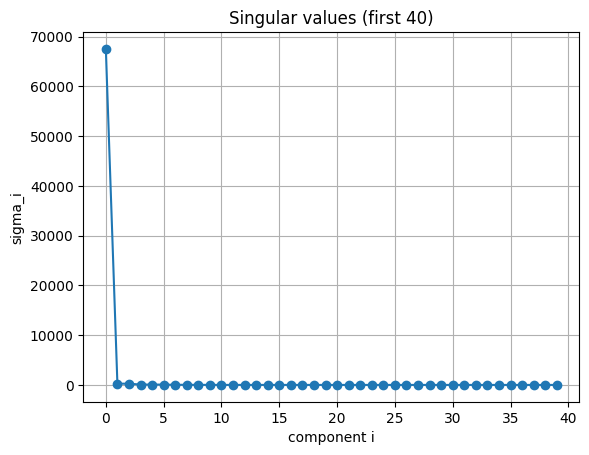

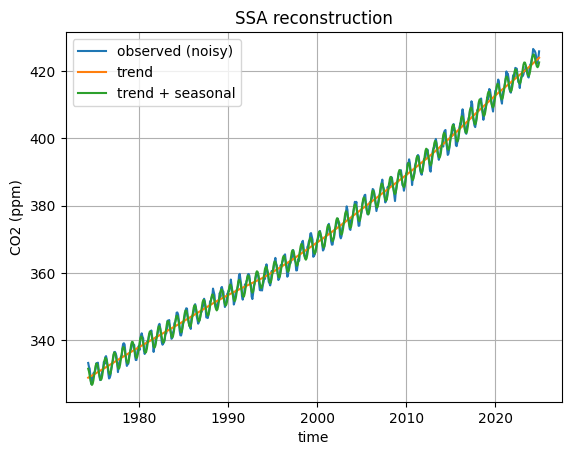

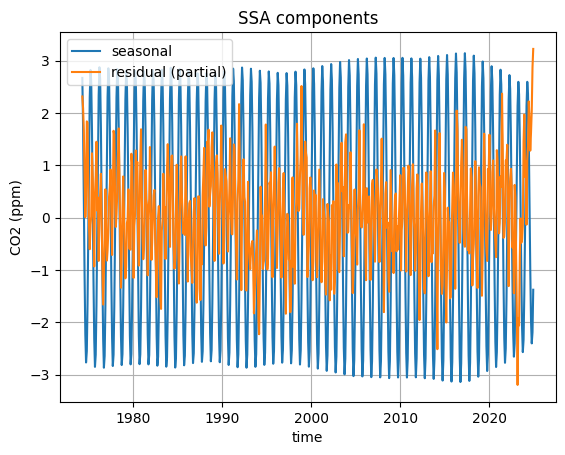

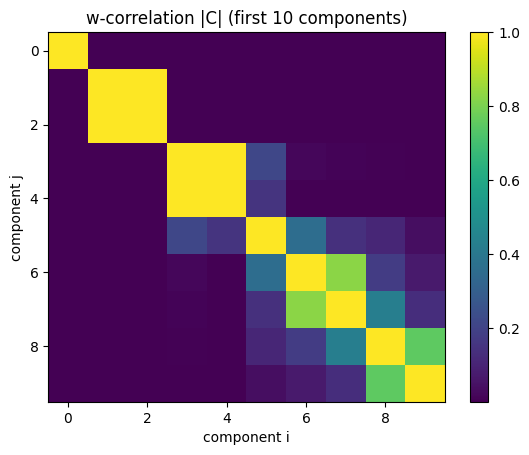

In [3]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Sequence, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests


# NOAA/GML の Mauna Loa 月次 CO2（テキスト）
NOAA_CO2_MONTHLY_TXT_URL = (
    "https://gml.noaa.gov/aftp/data/trace_gases/co2/in-situ/surface/txt/"
    "co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt"
)


@dataclass
class SSAResult:
    L: int
    X: np.ndarray
    U: np.ndarray
    s: np.ndarray
    Vt: np.ndarray


def download_file(url: str, dst: Path) -> None:
    """URLからファイルをダウンロードして保存する（既にある場合は呼ばない想定）。"""
    dst.parent.mkdir(parents=True, exist_ok=True)
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(dst, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 256):
                if chunk:
                    f.write(chunk)


def _try_parse_header_lines_value(line: str) -> Optional[int]:
    """
    例: "# header_lines : 159" から 159 を取りたいが、reを使わずにやる。
    見つからなければ None。
    """
    s = line.strip()
    if "header_lines" not in s:
        return None
    if ":" not in s:
        return None

    # ":" の右側を取り出して数字化を試す（空白や余計な文字は取り除く）
    right = s.split(":", 1)[1].strip()

    # right が "159" とか "159   " の想定。先頭から数字だけ拾う。
    digits = []
    for ch in right:
        if ch.isdigit():
            digits.append(ch)
        else:
            # 数字が1つでも取れていて、次が非数字なら打ち切る（"159," みたいなケース）
            if digits:
                break
    if not digits:
        return None
    return int("".join(digits))


def _looks_like_column_header(line: str) -> bool:
    """
    列名行（例: "site_code year month day ..."）かどうかを、
    reなしで「単語の集合」で判定する。

    あなたのスクショの列名は少なくとも
    site_code, year, month, day, hour, minute, second
    あたりを含むので、それで判定する。
    """
    tokens = line.strip().split()
    if not tokens:
        return False

    token_set = set(tokens)

    must_have = {"site_code", "year", "month"}
    if not must_have.issubset(token_set):
        return False

    # 追加の安全策：day/hour/minute/second のうち2個以上入ってたら列名行っぽい
    optional = {"day", "hour", "minute", "second", "datetime"}
    count_opt = sum(1 for t in optional if t in token_set)
    return count_opt >= 2


def scan_file_header(path: Path, max_scan_lines: int = 10000) -> Tuple[int, List[str], Dict[str, str], Optional[int]]:
    """
    ファイル先頭を走査して
      - ヘッダ行（# で始まる行）を header_text として保持
      - "# key: value" 形式のメタデータを meta 辞書に保持（reなし：splitで処理）
      - header_lines の数値（見つかれば）を header_lines_value に保持
      - 列名行（VARIABLE ORDER の後の "site_code year ..."）の行番号（0-based）を見つける

    返り値:
      header_lines_value: header_lines の宣言値（無ければ 0）
      header_text: 先頭のコメント行群（# の行）
      meta: key-value（# key: value）
      column_header_line_index: 列名行の位置（0-based）。見つからなければ None。
    """
    header_text: List[str] = []
    meta: Dict[str, str] = {}

    header_lines_value: Optional[int] = None
    column_header_line_index: Optional[int] = None

    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for line_idx in range(max_scan_lines):
            line = f.readline()
            if not line:
                break

            # コメント行は保持
            if line.lstrip().startswith("#"):
                header_text.append(line.rstrip("\n"))

                # "# key: value" を split だけでパース（reなし）
                # 例: "# dataset_name: co2_mlo_surface-..." など
                stripped = line.lstrip()[1:].strip()  # 先頭の "#" を落として両端空白除去
                if ":" in stripped:
                    key, val = stripped.split(":", 1)
                    key = key.strip()
                    val = val.strip()
                    if key and val:
                        meta[key] = val

                # header_lines 値があれば取る
                if header_lines_value is None:
                    v = _try_parse_header_lines_value(line)
                    if v is not None:
                        header_lines_value = v

            # 列名行検出（コメント行でなくてもOK：あなたのファイルは列名行がコメントでない）
            if column_header_line_index is None and _looks_like_column_header(line):
                column_header_line_index = line_idx
                # 列名行が見つかったら、以降のヘッダ走査は不要（必要なら続行でもよい）
                break

    if header_lines_value is None:
        header_lines_value = 0

    return header_lines_value, header_text, meta, column_header_line_index


def _read_table(path: Path, skiprows: int) -> pd.DataFrame:
    """
    表部分を読む。sep=r"\\s+" は「空白区切り」を意味する（reモジュールは不要）。
    """
    df = pd.read_csv(
        path,
        sep=r"\s+",
        skiprows=max(skiprows, 0),
        header=0,  # skiprowsで飛ばした直後の1行を列名として扱う
        na_values=[-999.99, -999.990, -999.9],
        engine="python",
    )
    return df


def load_noaa_co2_monthly(path: Path, hardcoded_skiprows: Optional[int] = None) -> Tuple[pd.Series, Dict[str, str], List[str]]:
    """
    NOAAテキストから「月次の CO2 時系列（pandas.Series）」を作る（re無し）。

    戦略:
    1) hardcoded_skiprows が指定されていれば、それを最優先で使う（完全ハードコード）
    2) 指定がなければ、ファイルを走査して「列名行」を検出し、その位置を skiprows に使う
    3) それでも見つからなければ、header_lines_value を頼って
       - まず header_lines_value - 1（列名行がheaderに含まれる想定）
       - ダメなら header_lines_value
       を試す
    """
    header_lines_value, header_text, meta, colhdr_idx = scan_file_header(path)

    # 1) 完全ハードコードモード
    if hardcoded_skiprows is not None:
        df = _read_table(path, skiprows=hardcoded_skiprows)

    else:
        # 2) 列名行の自動検出が成功したらそれを採用
        if colhdr_idx is not None:
            df = _read_table(path, skiprows=colhdr_idx)
        else:
            # 3) 予備策：header_lines_value に基づいて試行
            candidates = []
            if header_lines_value > 0:
                candidates.append(max(header_lines_value - 1, 0))
                candidates.append(header_lines_value)
            else:
                # 最終手段：あなたのケース向けに 158 を試す（失敗したら明示エラー）
                candidates.append(158)

            df = None
            last_cols = None
            for sk in candidates:
                tmp = _read_table(path, skiprows=sk)
                last_cols = list(tmp.columns)
                if ("year" in tmp.columns) and ("month" in tmp.columns) and ("site_code" in tmp.columns):
                    df = tmp
                    break

            if df is None:
                raise ValueError(
                    "Could not detect table header. Tried skiprows candidates: "
                    f"{candidates}, last columns={last_cols}"
                )

    # site_code があるなら MLO のみに絞る
    if "site_code" in df.columns:
        df = df[df["site_code"].astype(str).str.upper() == "MLO"].copy()

    # CO2値の列名候補（このファイルでは value が入っていることが多い）
    value_col_candidates = ["value", "co2", "co2_ppm", "co2ppm", "average", "mean"]
    value_col = None
    for c in value_col_candidates:
        if c in df.columns:
            value_col = c
            break
    if value_col is None:
        raise ValueError(f"Cannot find CO2 value column. columns={list(df.columns)}")

    # year/month/value を数値化（変換できないものは NaN にして落とす）
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["month"] = pd.to_numeric(df["month"], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=["year", "month", value_col]).copy()

    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].astype(int)

    idx = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    s = pd.Series(df[value_col].to_numpy(dtype=float), index=idx).sort_index()

    s = s.asfreq("MS")
    s = s.interpolate(limit_direction="both")

    return s, meta, header_text


def trajectory_matrix(x: np.ndarray, L: int) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if not (2 <= L <= N - 1):
        raise ValueError(f"L must satisfy 2 <= L <= N-1. Got L={L}, N={N}.")

    K = N - L + 1
    X = np.empty((L, K), dtype=float)
    for j in range(K):
        X[:, j] = x[j : j + L]
    return X


def diagonal_averaging(X: np.ndarray) -> np.ndarray:
    L, K = X.shape
    N = L + K - 1

    y = np.zeros(N, dtype=float)
    w = np.zeros(N, dtype=float)

    for i in range(L):
        for j in range(K):
            t = i + j
            y[t] += X[i, j]
            w[t] += 1.0

    return y / w


def ssa_fit(x: np.ndarray, L: int) -> SSAResult:
    X = trajectory_matrix(x, L)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    return SSAResult(L=L, X=X, U=U, s=s, Vt=Vt)


def reconstruct_matrix(ssa: SSAResult, indices: Sequence[int]) -> np.ndarray:
    idx = np.array(list(indices), dtype=int)
    U_I = ssa.U[:, idx]
    s_I = ssa.s[idx]
    Vt_I = ssa.Vt[idx, :]
    return (U_I * s_I) @ Vt_I


def reconstruct_series(ssa: SSAResult, indices: Sequence[int]) -> np.ndarray:
    X_I = reconstruct_matrix(ssa, indices)
    return diagonal_averaging(X_I)


def weights_for_wcorr(L: int, K: int) -> np.ndarray:
    N = L + K - 1
    w = np.zeros(N, dtype=float)
    for t in range(N):
        tt = t + 1
        w[t] = min(tt, L, K, N - tt + 1)
    return w


def wcorr_matrix(components: List[np.ndarray], L: int, K: int) -> np.ndarray:
    w = weights_for_wcorr(L, K)
    m = len(components)
    C = np.zeros((m, m), dtype=float)

    for i in range(m):
        xi = components[i]
        ni = np.sqrt(np.sum(w * xi * xi))

        for j in range(m):
            xj = components[j]
            nj = np.sqrt(np.sum(w * xj * xj))

            num = np.sum(w * xi * xj)
            C[i, j] = num / (ni * nj + 1e-15)

    return C


def main() -> None:
    data_dir = Path("data")
    txt_path = data_dir / "co2_mlo_monthly.txt"

    if not txt_path.exists():
        print("Downloading NOAA/GML Mauna Loa monthly CO2...")
        download_file(NOAA_CO2_MONTHLY_TXT_URL, txt_path)

    # 完全ハードコードしたいなら hardcoded_skiprows=158 を渡す
    # s, meta, header_text = load_noaa_co2_monthly(txt_path, hardcoded_skiprows=158)

    # 基本は「ファイルから自動検出」
    s, meta, header_text = load_noaa_co2_monthly(txt_path)

    if "dataset_name" in meta:
        print("dataset_name:", meta["dataset_name"])

    x_clean = s.to_numpy(dtype=float)

    rng = np.random.default_rng(0)
    noise_std = 0.6
    x = x_clean + rng.normal(0.0, noise_std, size=x_clean.shape[0])

    L = 60
    ssa = ssa_fit(x, L)

    plt.figure()
    plt.plot(ssa.s[:40], marker="o")
    plt.title("Singular values (first 40)")
    plt.xlabel("component i")
    plt.ylabel("sigma_i")
    plt.grid(True)

    trend_idx = [0]
    seasonal_idx = [1, 2]
    residual_idx = list(range(3, min(30, len(ssa.s))))

    x_trend = reconstruct_series(ssa, trend_idx)
    x_seasonal = reconstruct_series(ssa, seasonal_idx)
    x_residual = reconstruct_series(ssa, residual_idx)

    plt.figure()
    plt.plot(s.index, x, label="observed (noisy)")
    plt.plot(s.index, x_trend, label="trend")
    plt.plot(s.index, x_trend + x_seasonal, label="trend + seasonal")
    plt.title("SSA reconstruction")
    plt.xlabel("time")
    plt.ylabel("CO2 (ppm)")
    plt.legend()
    plt.grid(True)

    plt.figure()
    plt.plot(s.index, x_seasonal, label="seasonal")
    plt.plot(s.index, x_residual, label="residual (partial)")
    plt.title("SSA components")
    plt.xlabel("time")
    plt.ylabel("CO2 (ppm)")
    plt.legend()
    plt.grid(True)

    m = 10
    elementary_series = []
    for i in range(m):
        Xi = ssa.s[i] * np.outer(ssa.U[:, i], ssa.Vt[i, :])
        elementary_series.append(diagonal_averaging(Xi))

    L_, K_ = ssa.X.shape
    C = wcorr_matrix(elementary_series, L_, K_)

    plt.figure()
    plt.imshow(np.abs(C), aspect="auto")
    plt.title("w-correlation |C| (first 10 components)")
    plt.xlabel("component i")
    plt.ylabel("component j")
    plt.colorbar()

    plt.show()


if __name__ == "__main__":
    main()
